In [1]:
import pickle 
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import sys
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/scripts')
from processing_utils import *

In [3]:
for idx in range(20,25):
    with open("sim_model_4_{}.pkl".format(idx), "rb") as f:
        input_map, cost_map = pickle.load(f)
        input_map = input_map[:-5]
        cost_map = cost_map[:-5]
        input_map = input_map.reshape(6,256,256)
        model4_curr_map = input_map[-2]
        model4_goal_map = input_map[-1]
        model4_cost_map = cost_map.reshape(256,256)
        model4_start_img = np.zeros([256,256])
        model4_start_img[128,128] = 1
    with open("sim_model_5_{}.pkl".format(idx), "rb") as f:
        input_map, cost_map = pickle.load(f)
        input_map = input_map[:-5]
        cost_map = cost_map[:-5]
        input_map = input_map.reshape(6,256,256)
        model5_curr_map = input_map[-2]
        model5_goal_map = input_map[-1]
        model5_cost_map = cost_map.reshape(256,256)
        model5_start_img = np.zeros([256,256])
        model5_start_img[128,128] = 1
    plt.figure(figsize=[10,20])
    # cost_map[cost_map < 20] = 0
    plt.subplot(1,2,1)
    plt.title("costmap with data augmentation")
    img = model4_curr_map * 50 + model4_cost_map 
    img1 = cv2.circle(img,[128,128],1,[128,128,128],1)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    img = model5_curr_map * 50 + model5_cost_map 
    img2 = cv2.circle(img,[128,128],1,[128,128,128],1)
    plt.title("costmap without data augmentation")
    plt.imshow(img2)
plt.show()
# print(input_map[-2])

FileNotFoundError: [Errno 2] No such file or directory: 'sim_model_4_20.pkl'

In [ ]:
for idx in range(33,40):
    with open("sim_{}.pkl".format(idx), "rb") as f:
        input_map, cost_map = pickle.load(f)
        input_map = input_map[:-5]
        cost_map = cost_map[:-5]
        input_map = input_map.reshape(6,256,256)
        model4_curr_map = input_map[-2]
        model4_goal_map = input_map[-1]
        model4_cost_map = cost_map.reshape(256,256)
        model4_start_img = np.zeros([256,256])
        model4_start_img[128,128] = 1

    plt.figure(figsize=[10,20])
    # cost_map[cost_map < 20] = 0
    plt.subplot(1,2,1)
    plt.title("costmap with data augmentation")
    img = model4_cost_map 
    img1 = cv2.circle(img,[128,128],1,[128,128,128],1)
    plt.imshow(img1)
   
plt.show()
# print(input_map[-2])

In [2]:
import sys 
from pqdict import pqdict

import torch

In [3]:

def get_neighbor_indices(idx: int, H: int, W: int) -> np.array:
    """Get neighbor indices"""

    neighbor_indices = []
    if idx % W - 1 >= 0:
        neighbor_indices.append(idx - 1)
    if idx % W + 1 < W:
        neighbor_indices.append(idx + 1)
    if idx // W - 1 >= 0:
        neighbor_indices.append(idx - W)
    if idx // W + 1 < H:
        neighbor_indices.append(idx + W)
    if (idx % W - 1 >= 0) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W - 1)
    if (idx % W + 1 < W) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W + 1)
    if (idx % W - 1 >= 0) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W - 1)
    if (idx % W + 1 < W) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W + 1)

    return np.array(neighbor_indices)


def compute_chebyshev_distance(idx: int, goal_idx: int, W: int) -> float:
    """Compute chebyshev heuristic"""

    loc = np.array([idx % W, idx // W])
    goal_loc = np.array([goal_idx % W, goal_idx // W])
    dxdy = np.abs(loc - goal_loc)
    h = dxdy.sum() - dxdy.min()
    euc = np.sqrt(((loc - goal_loc) ** 2).sum())
    return h + 0.001 * euc


def get_history(close_list: list, H: int, W: int) -> np.array:
    """Get search history"""

    history = np.array([[idx % W, idx // W] for idx in close_list.keys()])
    history_map = np.zeros((H, W))
    history_map[history[:, 1], history[:, 0]] = 1

    return history_map


def backtrack(parent_list: list, goal_idx: int, H: int, W: int) -> np.array:
    """Backtrack to obtain path"""

    current_idx = goal_idx
    path = []
    while current_idx != None:
        path.append([current_idx % W, current_idx // W])
        current_idx = parent_list[current_idx]
    path = np.array(path)
    path_map = np.zeros((H, W))
    path_map[path[:, 1], path[:, 0]] = 1

    return path_map, path

def solve_single(
    pred_cost: np.array,
    start_map: np.array,
    goal_map: np.array,
    map_design: np.array,
    g_ratio: float = 0.5,
) -> list:
    """Solve a single problem"""

    H, W = map_design.shape
    start_idx = np.argwhere(start_map.flatten()).item()
    goal_idx = np.argwhere(goal_map.flatten()).item()
    map_design_vct = map_design.flatten()
    pred_cost_vct = pred_cost.flatten()
    open_list = pqdict()
    close_list = pqdict()
    open_list.additem(start_idx, 0)
    parent_list = dict()
    parent_list[start_idx] = None

    num_steps = 0
    while goal_idx not in close_list:
        if len(open_list) == 0:
            print("goal not found")
            return np.zeros_like(goal_map), np.zeros_like(goal_map)
        num_steps += 1
        v_idx, v_cost = open_list.popitem()
        close_list.additem(v_idx, v_cost)
        for (id, n_idx) in enumerate(get_neighbor_indices(v_idx, H, W)):
            if id < 4:
                step_cost = 1
            else:
                step_cost = np.sqrt(2)
            if map_design_vct[n_idx] == 1:
                f_new = (
                    v_cost
                    - (1 - g_ratio)
                    * compute_chebyshev_distance(v_idx, goal_idx, W)
                    + g_ratio * pred_cost_vct[n_idx]
                    + (1 - g_ratio) * compute_chebyshev_distance(n_idx, goal_idx, W)
                    + step_cost
                )

                # conditions for the nodes not yet in the open list nor closed list
                cond = (n_idx not in open_list) & (n_idx not in close_list)

                # condition for the nodes already in the open list but with larger f value
                if n_idx in open_list:
                    cond = cond | (open_list[n_idx] > f_new)

                if cond:
                    try:
                        open_list.additem(n_idx, f_new)
                    except:
                        open_list[n_idx] = f_new
                    parent_list[n_idx] = v_idx

    history_map = get_history(close_list, H, W)
    path_map, path = backtrack(parent_list, goal_idx, H, W)
    return history_map, path_map, path

50.0


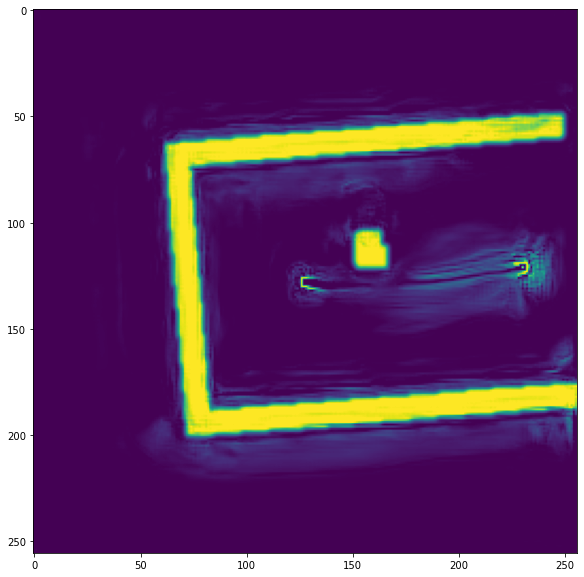

In [4]:
with open("pkl/sim_{}.pkl".format(7), "rb") as f: # 239
    input_map, cost_map = pickle.load(f)
    input_map = input_map[:-5]
    cost_map = cost_map[:-5]
    input_map = input_map.reshape(6,256,256)
    model4_curr_map = input_map[-2]
    model4_goal_map = input_map[-1]
    model4_cost_map = cost_map.reshape(256,256)
    model4_start_img = np.zeros([256,256])
    model4_start_img[128,128] = 1

    # model4_cost_map = torch.tensor(model4_cost_map).unsqueeze(0).unsqueeze(0)
    # model4_start_img = torch.tensor(model4_start_img).unsqueeze(0).unsqueeze(0)
    # model4_goal_map = torch.tensor(model4_goal_map).unsqueeze(0).unsqueeze(0)
# model4_cost_map[model4_cost_map < 10] = 0

# y = np.nonzero(model4_goal_map)[0][0]
# x = np.nonzero(model4_goal_map)[1][0]
# print(x,y)

# model4_cost_map[120:136,128:136] = 0
# model4_cost_map[np.nonzero(model4_goal_map)] = 0
# model4_cost_map[y-5:y+5, x-5:x+5] = 0
print(np.max(model4_cost_map))
# history_map, path_map, path= solve_single(model4_cost_map, model4_start_img, model4_goal_map, np.ones([256,256]))
# map_design[118:138,118:138] = 1
# print(path)
plt.figure(figsize=[10,10])
plt.imshow(
            # path_map *50+
           model4_cost_map 
        #    model4_goal_map*50 
        #    +model4_curr_map * 50
           )
# plt.imshow(history_map)
plt.show()

In [38]:
maps = []
for i in range(250,290):
    with open("pkl/sim_{}.pkl".format(i), "rb") as f: # 239
        input_map, cost_map = pickle.load(f)
        input_map = input_map[:-5]
        cost_map = cost_map[:-5]
        input_map = input_map.reshape(6,256,256)
        model4_curr_map = input_map[-2]
        model4_goal_map = input_map[-1]
        model4_cost_map = cost_map.reshape(256,256)
        model4_start_img = np.zeros([256,256])
        model4_start_img[128,128] = 1
        maps.append(model4_cost_map)

        # model4_cost_map = torch.tensor(model4_cost_map).unsqueeze(0).unsqueeze(0)
        # model4_start_img = torch.tensor(model4_start_img).unsqueeze(0).unsqueeze(0)
        # model4_goal_map = torch.tensor(model4_goal_map).unsqueeze(0).unsqueeze(0)
    # model4_cost_map[model4_cost_map < 10] = 0

    # y = np.nonzero(model4_goal_map)[0][0]
    # x = np.nonzero(model4_goal_map)[1][0]
    # print(x,y)

    # model4_cost_map[120:136,128:136] = 0
    # model4_cost_map[np.nonzero(model4_goal_map)] = 0
    # model4_cost_map[y-5:y+5, x-5:x+5] = 0
    print(np.max(model4_cost_map))
    # history_map, path_map, path= solve_single(model4_cost_map, model4_start_img, model4_goal_map, np.ones([256,256]))
    # map_design[118:138,118:138] = 1
    # print(path)
    # plt.figure(figsize=[10,10])
    # plt.imshow(
    #             # path_map *50+
    #         model4_cost_map 
    #         #    model4_goal_map*50 
    #         #    +model4_curr_map * 50
    #         )
    # plt.imshow(history_map)
    # plt.show()
generate_gif(maps, "costmap")

50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0


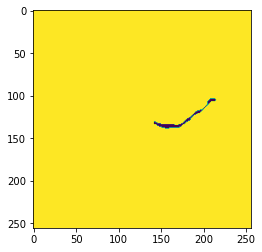

In [14]:
plt.imshow(history_map3)
